Este primer script usa el modelo de embeddings all-MiniLM-L6-v2 y se pasan esos embeddings a una red neuronal para calcular la similitud entre dos textos.

La red nueronal tiene como entrada los embeddings de los dos textos, concatenados con otro embedding que es la diferencia entre los dos textos y otro que es la multiplicación entre ambos. Luego, la salida es de 1 dimensión, que representa la similitud entre los textos.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import mean_squared_error


In [2]:
# Leer el archivo CSV 
df = pd.read_csv('../plain_text_resume_data.csv')
print("Largo total del dataset:", len(df))
# Shuffle el dataset
df = df.sample(frac=1, random_state=12).reset_index(drop=True)
df_train = df[:int(len(df) * 0.8)]
df_test = df[int(len(df) * 0.8):]
print("Largo del dataset de entrenamiento:", len(df_train))
print("Largo del dataset de prueba:", len(df_test))

Largo total del dataset: 9544
Largo del dataset de entrenamiento: 7635
Largo del dataset de prueba: 1909


In [20]:
# Cargar el modelo pre-entrenado desde Hugging Face

ST_model = SentenceTransformer('all-MiniLM-L6-v2')  # Rápido para similaridad

#model = SentenceTransformer("BAAI/bge-base-en-v1.5")

#from transformers import AutoModel
#model = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5", torch_dtype=torch.float16)


In [35]:
def calculate_embeddings(row, score=True):
    cv_text = row.iloc[0]
    job_description = row.iloc[1]
    # Obtener embeddings
    cv_embedding = ST_model.encode(cv_text, convert_to_tensor=True, normalize_embeddings=True)
    job_embedding = ST_model.encode(job_description, convert_to_tensor=True, normalize_embeddings=True)

    if score:
        # Si se requiere el score real, se asume que está en la tercera columna del DataFrame. Si no, se puede omitir esta parte.
        real_score = row.iloc[2]
        return cv_embedding, job_embedding, real_score
    
    return cv_embedding, job_embedding

In [22]:
embedding_dim = ST_model.get_sentence_embedding_dimension()
print("Dimensión de los embeddings:", embedding_dim)

Dimensión de los embeddings: 384


In [23]:

class JobMatchingNN(nn.Module):
    def __init__(self, embedding_dim):
        super(JobMatchingNN, self).__init__()
        self.fc1 = nn.Linear(4 * embedding_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()  # para score entre 0 y 1

    def forward(self, emb1, emb2):
        abs_diff = torch.abs(emb1 - emb2) 
        prod = emb1 * emb2
        # la diferencia absoluta y el producto se concatenan para tener más información sobre la relación entre los embeddings
        x = torch.cat([emb1, emb2, abs_diff, prod], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.out(x))
        return x


In [44]:
def graficar_resultados(real_scores, predicted_scores, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(real_scores, predicted_scores, alpha=0.5)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
    plt.xlabel('Score Real')
    plt.ylabel('Score Predicho')
    plt.title(title)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

In [24]:
'''
# Crear el trainset 
trainset = []
for i in tqdm.tqdm(range(len(df_train))):
    row = df_train.iloc[i]
    cv_embedding, job_embedding, real_score = calculate_embeddings(row)
    trainset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))

# guardar el trainset
torch.save(trainset, 'trainset_first_nn.pt')
'''

"\n# Crear el trainset \ntrainset = []\nfor i in tqdm.tqdm(range(len(df_train))):\n    row = df_train.iloc[i]\n    cv_embedding, job_embedding, real_score = calculate_embeddings(row)\n    trainset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))\n\n# guardar el trainset\ntorch.save(trainset, 'trainset_first_nn.pt')\n"

In [25]:
'''
# Crear el testset
testset = []
for i in tqdm.tqdm(range(len(df_test))):
    row = df_test.iloc[i]
    cv_embedding, job_embedding, real_score = calculate_embeddings(row)
    testset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))

# guardar el testset
torch.save(testset, 'testset_first_nn.pt')
'''

"\n# Crear el testset\ntestset = []\nfor i in tqdm.tqdm(range(len(df_test))):\n    row = df_test.iloc[i]\n    cv_embedding, job_embedding, real_score = calculate_embeddings(row)\n    testset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))\n\n# guardar el testset\ntorch.save(testset, 'testset_first_nn.pt')\n"

In [26]:
trainset = torch.load('trainset_first_nn.pt')
testset = torch.load('testset_first_nn.pt')

In [27]:
# Crear el modelo
model = JobMatchingNN(embedding_dim)
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Definir el número de épocas
num_epochs = 20
# Definir el tamaño del batch
batch_size = 16

# Crear un DataLoader para el conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# Crear un DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)


In [28]:
# Entrenar el modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (cv_embedding, job_embedding, real_score) in enumerate(tqdm.tqdm(train_loader)):
        optimizer.zero_grad()
        outputs = model(cv_embedding.float(), job_embedding.float())
        loss = criterion(outputs, real_score.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

100%|██████████| 478/478 [00:01<00:00, 456.52it/s]


Epoch [1/20], Loss: 0.0175


100%|██████████| 478/478 [00:01<00:00, 315.99it/s]


Epoch [2/20], Loss: 0.0125


100%|██████████| 478/478 [00:01<00:00, 312.45it/s]


Epoch [3/20], Loss: 0.0110


100%|██████████| 478/478 [00:01<00:00, 318.95it/s]


Epoch [4/20], Loss: 0.0102


100%|██████████| 478/478 [00:01<00:00, 310.64it/s]


Epoch [5/20], Loss: 0.0093


100%|██████████| 478/478 [00:01<00:00, 273.46it/s]


Epoch [6/20], Loss: 0.0088


100%|██████████| 478/478 [00:02<00:00, 225.26it/s]


Epoch [7/20], Loss: 0.0085


100%|██████████| 478/478 [00:01<00:00, 253.25it/s]


Epoch [8/20], Loss: 0.0079


100%|██████████| 478/478 [00:01<00:00, 294.87it/s]


Epoch [9/20], Loss: 0.0074


100%|██████████| 478/478 [00:01<00:00, 299.25it/s]


Epoch [10/20], Loss: 0.0074


100%|██████████| 478/478 [00:01<00:00, 287.42it/s]


Epoch [11/20], Loss: 0.0068


100%|██████████| 478/478 [00:01<00:00, 305.22it/s]


Epoch [12/20], Loss: 0.0068


100%|██████████| 478/478 [00:01<00:00, 298.33it/s]


Epoch [13/20], Loss: 0.0065


100%|██████████| 478/478 [00:01<00:00, 302.40it/s]


Epoch [14/20], Loss: 0.0063


100%|██████████| 478/478 [00:01<00:00, 303.57it/s]


Epoch [15/20], Loss: 0.0061


100%|██████████| 478/478 [00:01<00:00, 286.98it/s]


Epoch [16/20], Loss: 0.0058


100%|██████████| 478/478 [00:01<00:00, 282.15it/s]


Epoch [17/20], Loss: 0.0056


100%|██████████| 478/478 [00:01<00:00, 301.86it/s]


Epoch [18/20], Loss: 0.0055


100%|██████████| 478/478 [00:01<00:00, 290.38it/s]


Epoch [19/20], Loss: 0.0053


100%|██████████| 478/478 [00:01<00:00, 291.73it/s]

Epoch [20/20], Loss: 0.0052


100%|██████████| 1909/1909 [00:00<00:00, 6913.65it/s]


RMSE: 0.0936


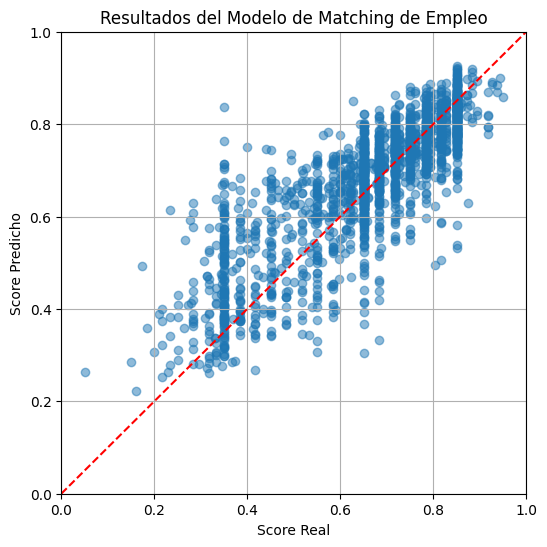

In [45]:
# Evaluar el modelo
model.eval()
predictions = []
real_scores = []
with torch.no_grad():
    for i, (cv_embedding, job_embedding, real_score) in enumerate(tqdm.tqdm(test_loader)):
        outputs = model(cv_embedding.float(), job_embedding.float())
        predictions.extend(outputs)
        real_scores.extend(real_score)
       
# Calcular la precisión
rmse = mean_squared_error(real_scores, predictions) ** 0.5
print(f"RMSE: {rmse:.4f}")
# Graficar los resultados
graficar_resultados(real_scores, predictions, "Resultados del Modelo de Matching de Empleo")


In [43]:
# Evaluar en dos casos particulares

# Buen caso
df_good = pd.read_csv('cv_jd_good_fit.csv')
cv_good_embedding, job_good_embedding = calculate_embeddings(df_good.iloc[0], score=False)
cv_good_embedding = torch.tensor(cv_good_embedding).float().unsqueeze(0)
job_good_embedding = torch.tensor(job_good_embedding).float().unsqueeze(0)
model.eval()
with torch.no_grad():
    good_output = model(cv_good_embedding, job_good_embedding)
    print(f"Predicción para buen caso: {good_output.item():.4f}")

# Mal caso
df_bad = pd.read_csv('cv_jd_bad_fit.csv')
cv_bad_embedding, job_bad_embedding = calculate_embeddings(df_bad.iloc[0], score=False)
cv_bad_embedding = torch.tensor(cv_bad_embedding).float().unsqueeze(0)
job_bad_embedding = torch.tensor(job_bad_embedding).float().unsqueeze(0)
model.eval()
with torch.no_grad():
    bad_output = model(cv_bad_embedding, job_bad_embedding)
    print(f"Predicción para mal caso: {bad_output.item():.4f}")


Predicción para buen caso: 0.7510
Predicción para mal caso: 0.5902


/tmp/ipykernel_27618/3562862592.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cv_good_embedding = torch.tensor(cv_good_embedding).float().unsqueeze(0)
/tmp/ipykernel_27618/3562862592.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  job_good_embedding = torch.tensor(job_good_embedding).float().unsqueeze(0)
/tmp/ipykernel_27618/3562862592.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cv_bad_embedding = torch.tensor(cv_bad_embedding).float().unsqueeze(0)
/tmp/ipykernel_27618/3562862592.py:17: UserWarning: To copy construct fr